## TITLE


imports

In [4]:
import os
import pandas as pd
import numpy as np

#vader
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

#sentiment analysis. svm and lr
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import text

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


LOAD FILES


In [5]:
BASE_PATH = "../data/raw"

files = [
    "1429_1.csv",
    "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",
    "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
]

dfs = {}

for file in files:
    path = os.path.join(BASE_PATH, file)
    print(f"Loading {file}...")
    temp_df = pd.read_csv(path, encoding="utf-8", low_memory=False)

    # Add column to know source file (useful to remove duplicates)
    temp_df["source_file"] = file

    dfs[file] = temp_df

print("Loading complete")

Loading 1429_1.csv...
Loading Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv...
Loading Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv...
Loading complete


PREPROCESSING

quick EDA

In [6]:
for name, df in dfs.items():
    print("\n" + "="*80)
    print(f"DATASET: {name}")
    print("="*80)
    
    print("\nShape:", df.shape)
    print("\nColumns:")
    print(df.columns.tolist())
    
    print("\nTypes:")
    print(df.dtypes)
    
    print("\nNaN per column:")
    print(df.isna().sum().sort_values(ascending=False).head(20))
    
    print("\nPreview:")
    display(df.head())


DATASET: 1429_1.csv

Shape: (34660, 22)

Columns:
['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file']

Types:
id                       object
name                     object
asins                    object
brand                    object
categories               object
keys                     object
manufacturer             object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating          float64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
rev

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,source_file
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter,1429_1.csv
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman,1429_1.csv
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,1429_1.csv
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks,1429_1.csv
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42,1429_1.csv



DATASET: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv

Shape: (5000, 25)

Columns:
['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs', 'source_file']

Types:
id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateAdded       object
reviews.dateSeen        object
reviews.doRecommend       bool
review

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,source_file
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...,Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...



DATASET: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv

Shape: (28332, 25)

Columns:
['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand', 'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer', 'manufacturerNumber', 'reviews.date', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs', 'source_file']

Types:
id                      object
dateAdded               object
dateUpdated             object
name                    object
asins                   object
brand                   object
categories              object
primaryCategories       object
imageURLs               object
keys                    object
manufacturer            object
manufacturerNumber      object
reviews.date            object
reviews.dateSeen        object
reviews.didPurchase     object
reviews.doRecommend     obje

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,source_file
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",Datafiniti_Amazon_Consumer_Reviews_of_Amazon_P...


Merging tables

In [7]:
# see common columns
common_columns = set(next(iter(dfs.values())).columns)

for df in dfs.values():
    common_columns = common_columns.intersection(df.columns)

common_columns = sorted(list(common_columns))

print("Number of common columns:", len(common_columns))
print(common_columns)



Number of common columns: 18
['asins', 'brand', 'categories', 'id', 'keys', 'manufacturer', 'name', 'reviews.date', 'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.username', 'source_file']


In [8]:
# reduce dataset to common columns

dfs_common = {}

for name, df in dfs.items():
    dfs_common[name] = df[common_columns].copy()


In [9]:
# clean merge

df_merged = pd.concat(dfs_common.values(), ignore_index=True)

print("Shape after merge:", df_merged.shape)


Shape after merge: (67992, 18)


Removing duplicates

We remove duplicates before dropping unnecessary columns because we're interested in duplicates derived from merging different tables, not unintended duplicated info (e.g. generic review texts like "great value" for the same product). Some of the unnecesarry columns for the project are useful for removing duplicates. Also, for the same reason, not normalizing and using a max subset


In [10]:
# exact rows duplicates

dup_mask_all = df_merged.duplicated(
    subset=common_columns,
    keep=False
)

duplicates_all = df_merged[dup_mask_all]

print("Total fully identical duplicates:", duplicates_all.shape[0])


Total fully identical duplicates: 190


In [11]:
# strong duplicates (same user, key, product, review, etc.)

duplicate_subset = [
    "keys",
    "reviews.username",
    "name",
    "brand",
    "reviews.title",
    "reviews.text",
    "reviews.rating"
]

dup_mask_strong = df_merged.duplicated(
    subset=duplicate_subset,
    keep=False
)

duplicates_strong = df_merged[dup_mask_strong]

print("Total logical duplicates:", duplicates_strong.shape[0])


Total logical duplicates: 2826


In [12]:
#checking source of duplicates
duplicates_strong.groupby("source_file").size()


source_file
1429_1.csv                                                          107
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv          1390
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv    1329
dtype: int64

In [13]:
# remove duplicates
df_merged = df_merged.drop_duplicates(
    subset=duplicate_subset
).reset_index(drop=True)

print("Shape after removing duplicates:", df_merged.shape)



Shape after removing duplicates: (66568, 18)


Working df

In [14]:
# keeping only relevant columns

columns_to_keep = [
    "id",
    "asins",
    "name",
    "brand",
    "manufacturer",
    'categories',
    "reviews.title",
    "reviews.text",
    "reviews.rating",
    "reviews.doRecommend",
    'reviews.numHelpful',
]

df = df_merged[columns_to_keep].copy()


print("Shape after dropping unused columns:", df.shape)


Shape after dropping unused columns: (66568, 11)


In [15]:
# remove nan and empty
df["reviews.title"] = df["reviews.title"].fillna("")
df["reviews.text"] = df["reviews.text"].fillna("")

df = df[
    ~(
        (df["reviews.title"].str.strip() == "") &
        (df["reviews.text"].str.strip() == "")
    )
]

print("Shape after removing rows without title AND text:", df.shape)


Shape after removing rows without title AND text: (66568, 11)


Adding full review column

In [16]:
df["full_review"] = (
    df["reviews.title"].fillna("") + " " +
    df["reviews.text"].fillna("")
).str.strip()

INSTRUCTIONS SUMMARY
Sentiment analysis
first task: unsupervised, sentiment model. Pos 0.92 neg .12 neg .05
reviews
rating(1-5)
results: only cateogrical. Pos. NEt. Neg

1000 products positive
second task: sort by rating.

Top 3 products. Bottom 3.
favor onger?


Clustering:
unsupervised
(optional supervised, checking against primarycategories)

make 1 csv file that contains info from sentiment and cluster. that feeds model 3: summary of reviews. 

add product id

SENTIMENT ANALYSIS
Goal. Classify product reviews in Positive, negative, neutral.

TODO. Missing removal of discrepancies good review - bad rating. (con vader?)(a posteriori del análisis?)

Preprocessing for Sentiment analysis

In [17]:
# Creating df for sentiment analysis
df["full_review"] = (
    df["reviews.title"].fillna("") + " " +
    df["reviews.text"].fillna("")
).str.strip()

In [18]:
df_sa = df.copy()
df_sa = df[df["full_review"] != ""]

In [19]:
# mapping category to rating numbers
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df_sa["aux_sentiment"] = df_sa["reviews.rating"].apply(map_sentiment)


In [20]:
# check category distribution
print(df_sa["aux_sentiment"].value_counts())
print(df_sa["aux_sentiment"].value_counts(normalize=True))

aux_sentiment
positive    61264
neutral      2838
negative     2466
Name: count, dtype: int64
aux_sentiment
positive    0.920322
neutral     0.042633
negative    0.037045
Name: proportion, dtype: float64


Train / test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sa["full_review"],
    df_sa["aux_sentiment"],
    test_size=0.2,
    stratify=df_sa["aux_sentiment"],
    random_state=42
)

SVM CLASSIFIER

In [22]:
# pipeline

svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2), 
        stop_words="english"
    )),
    ("clf", LinearSVC(
        class_weight="balanced", # to compensate for unbalanced dataset
        random_state=42
    ))
])

Training

In [23]:
svm_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


Evaluation

In [24]:

y_pred_svm = svm_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75       493
     neutral       0.56      0.54      0.55       568
    positive       0.98      0.98      0.98     12253

    accuracy                           0.95     13314
   macro avg       0.76      0.76      0.76     13314
weighted avg       0.95      0.95      0.95     13314



In [25]:
# dummy classifier as reference to check if model predicts well or accuracy is based on having an unbalanced dataset

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_dummy = dummy.predict(X_test)

print("SVM - Classification Report")
print(classification_report(y_test, y_dummy))


SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       493
     neutral       0.00      0.00      0.00       568
    positive       0.92      1.00      0.96     12253

    accuracy                           0.92     13314
   macro avg       0.31      0.33      0.32     13314
weighted avg       0.85      0.92      0.88     13314



c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Interpretation

General interpretation: Model is learning also for minority categories (negative and neutral) as seen in comparison with dummy classifier.
Macro F1 0.32 → 0.76 is significant. Class_wright = balanced is working.

Identifying negative:
Precision: 0.77
Recall: 0.76
F1: 0.77
Solid enough for a class that is only 3.7 % of the dataset.

Identifying neutral:
Precision: 0.57
Recall: 0.52
F1: 0.54
As expected, this is the most difficult category to identify correctly as it is often classified as positive and negative.
227 neutrals classified as positive. Likely due to mild positive language.

Confusion matrix

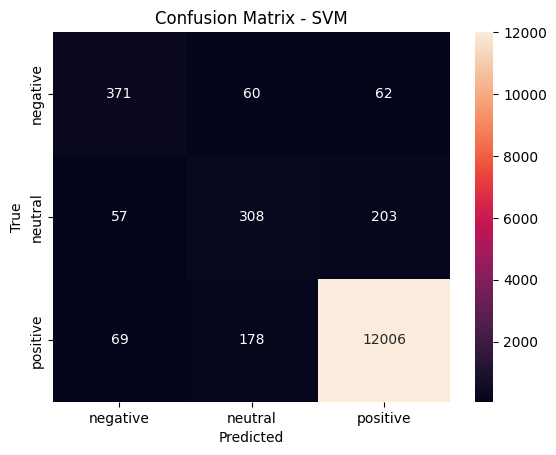

In [26]:
cm = confusion_matrix(y_test, y_pred_svm, labels=["negative","neutral","positive"])

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix - SVM")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


Check confusion matrix. negative for positive

Cross-validation

In [27]:
# define cross-validation parameters (stratidiedKfold) 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# execute cross validation
svm_cv_scores = cross_val_score(
    svm_pipeline,
    df_sa["full_review"],
    df_sa["aux_sentiment"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("F1-macro scores per fold:", svm_cv_scores)
print("Mean F1-macro:", svm_cv_scores.mean())
print("Std deviation:", svm_cv_scores.std())

F1-macro scores per fold: [0.74964739 0.76804159 0.7728623  0.76115571 0.75352202]
Mean F1-macro: 0.7610458022826522
Std deviation: 0.008661567923969027


Conclusion
Std deviation: 0.005247618035412601
Very low standard deviation, model is stable, doesn't depend much on the split.
Expected performance around 76%.

LOGISTIC REGRESSION CLASSIFIER

In [28]:
# pipeline

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced", # to compensate for unbalanced dataset
        solver="lbfgs"
    ))
])

training

In [29]:
lr_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


Evaluation

In [30]:
y_pred_lr = lr_pipeline.predict(X_test)

In [31]:

print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.56      0.82      0.66       493
     neutral       0.31      0.69      0.43       568
    positive       0.99      0.91      0.95     12253

    accuracy                           0.90     13314
   macro avg       0.62      0.81      0.68     13314
weighted avg       0.94      0.90      0.92     13314



Comparison SVM vs LR

In [32]:
# macro f1 score
# svm f1 score
macro_f1_svm = f1_score(y_test, y_pred_svm, average="macro")
print("SVM - Macro F1:", macro_f1_svm)
# lr f1 score
macro_f1_lr = f1_score(y_test, y_pred_lr, average="macro")
print("Logistic Regression - Macro F1:", macro_f1_lr)


SVM - Macro F1: 0.7605265799241905
Logistic Regression - Macro F1: 0.6819440718221031


In [33]:
# pasting classification reports again for analysis convenience
print("SVM - Classification Report")
print(classification_report(y_test, y_dummy))
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred_lr))

SVM - Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       493
     neutral       0.00      0.00      0.00       568
    positive       0.92      1.00      0.96     12253

    accuracy                           0.92     13314
   macro avg       0.31      0.33      0.32     13314
weighted avg       0.85      0.92      0.88     13314

Logistic Regression - Classification Report
              precision    recall  f1-score   support

    negative       0.56      0.82      0.66       493
     neutral       0.31      0.69      0.43       568
    positive       0.99      0.91      0.95     12253

    accuracy                           0.90     13314
   macro avg       0.62      0.81      0.68     13314
weighted avg       0.94      0.90      0.92     13314



c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santi\devtools\anaconda3\envs\ironhack\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Interpretation

The Linear SVM clearly outperforms Logistic Regression in multiclass sentiment classification, achieving a substantially higher macro F1-score and a better balance between precision and recall across the minority classes

Conclusion

Therefore, We'll use the Linear SVM as the primary classification model due to its superior performance, while Logistic Regression is employed to estimate sentiment intensity through its probabilistic outputs.

The decision function (distance to the plane) from the SVM could be use as a sort of grading and sorting mechanism, but it's a worse solution than LR for sorting, and more importantly in our case, when looking for reviews of extreme intensity (positive and negative)

CATEGORY CLUSTERING

Preprocessing

Understanding Asins vs id

We know in Amazon ASINS (by definition) are unique identifiers for products (regardless of who is selling them), but we are unsure of what ids are in this dataset and which one to use as unique identifier

In [34]:
print("Unique ASINs:", df["asins"].nunique())
print("Unique IDs:", df["id"].nunique())
print("Total rows:", len(df))

Unique ASINs: 94
Unique IDs: 92
Total rows: 66568


In [35]:
#how many id per asin
asin_id_counts = (
    df.groupby("asins")["id"]
      .nunique()
      .sort_values(ascending=False)
)

print(asin_id_counts.describe())
print("Max IDs per ASIN:", asin_id_counts.max())
multiple_ids = asin_id_counts[asin_id_counts > 1]
print("ASINs with multiple IDs:", len(multiple_ids))


count    94.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: id, dtype: float64
Max IDs per ASIN: 1
ASINs with multiple IDs: 0


In [36]:
# how many asins per id
id_asin_counts = (
    df.groupby("id")["asins"]
      .nunique()
      .sort_values(ascending=False)
)

print(id_asin_counts.describe())
print("Max ASINs per ID:", id_asin_counts.max())
multiple_asins = id_asin_counts[id_asin_counts > 1]
print("IDs with multiple ASINs:", len(multiple_asins))


count    92.000000
mean      1.021739
std       0.208514
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: asins, dtype: float64
Max ASINs per ID: 2
IDs with multiple ASINs: 3


In [37]:
#inspect ids with multiple asins
df[df["id"].isin(multiple_asins.index)].sort_values("id")

,id,asins,name,brand,manufacturer,categories,reviews.title,reviews.text,reviews.rating,reviews.doRecommend,reviews.numHelpful,full_review
26537,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",Amazon,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",Learn something new everyday with the echo,Every time I use the echo I find there is some...,5.0,True,0.0,Learn something new everyday with the echo Eve...
26280,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",Amazon,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",Great with kids,I don't use it nearly as much as I could. The ...,5.0,True,0.0,Great with kids I don't use it nearly as much ...
26279,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",Amazon,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",It's a lot of fun and my husband is enjoying it.,We're just setting it up now. There is a lot o...,5.0,True,0.0,It's a lot of fun and my husband is enjoying i...
26278,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",Amazon,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...",Fun new gadget,It has been nice having the echo love it bough...,5.0,True,0.0,Fun new gadget It has been nice having the ech...
26277,AVpfl8cLLJeJML43AE3S,"B00L9EPT8O,B01E6AO69U","Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",Amazon,Amazon,"Stereos,Remote Controls,Amazon Echo,Audio Dock...","Excellent device, love it!!","Does a great job of playing music, getting new...",4.0,True,0.0,"Excellent device, love it!! Does a great job o..."
...,...,...,...,...,...,...,...,...,...,...,...,...
54106,AVqVGWQDv8e3D1O-ldFr,"B018SZT3BK,B01AHB9CN2","All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Good value and Samsung quality!,"Most of the time I use the tablet for the Web,...",4.0,True,0.0,Good value and Samsung quality! Most of the ti...
54108,AVqVGWQDv8e3D1O-ldFr,"B018SZT3BK,B01AHB9CN2","All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",good value for kindle fire hd 8,Best Buy has a good price structure for the Ki...,5.0,True,0.0,good value for kindle fire hd 8 Best Buy has a...
54109,AVqVGWQDv8e3D1O-ldFr,"B018SZT3BK,B01AHB9CN2","All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Fire Tablets,Computers/Tablets & Networking,El...",Good value for the price,For the most part I like the tablet. Got it fo...,4.0,True,0.0,Good value for the price For the most part I l...
54114,AVqVGWQDv8e3D1O-ldFr,"B018SZT3BK,B01AHB9CN2","All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Fire Tablets,Computers/Tablets & Networking,El...","Good, not great",Good reader which is why I bought it. Ads are ...,4.0,True,0.0,"Good, not great Good reader which is why I bou..."


In [38]:
# inspect IDs with 0 ASINs
id_asin_counts[id_asin_counts == 0]
#no need to clean it after we decide to use id as identifier

id
AVpioXbb1cnluZ0-PImd    0
Name: asins, dtype: int64

Conclusion

Despite knowing ASIN is the term for unique products on amazon, we decided to use id as the product identifier because it provides a nearly one-to-one mapping with ASINs in this dataset and represents a cleaner, more stable unit of analysis. Given the ambiguity in how the dataset creator used the asins field and the presence of multiple ASINs per ID in a few cases, using id avoids unnecessary data expansion. Performing an explode operation could artificially duplicate entries and potentially distort subsequent clustering and statistical analyses.

Normalize ASINs column

Clustering Approach 

We will perform unsupervised product-level clustering using a classical NLP pipeline.

Aggregation Level (Product-Level Clustering)
Clustering will be performed at the product level (ASIN), not on individual reviews.
For each product, we will aggregate textual information including:
Product name, Brand, Manufacturer, Concatenated review texts.

We will use KMeans clustering, testing values of k=4,5,6, as suggested in the project guidelines. We will then evaluate clustering quality using the Silhouette Score and select the number of clusters that maximizes separation and cohesion.

extracting product category

In [39]:
#checking format
print(df["categories"][5])
type(df["categories"][5])

Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets


str

In [40]:
#add a column to df with the last 2 sections of the "categories" string. To obtain a representative category for each registry
df["extracted_category"] = df["categories"].apply(
    lambda x: " ".join([c.strip() for c in x.split(",")[-3:]])
    if isinstance(x, str) and x.strip() != ""
    else ""
)

In [41]:
#retaking df and creating df_cluster for this task
cols_needed = [
    "id",
    "name",
    "extracted_category"
    #"brand", # removing as there's a large part of the dataset with same brand for different products (amazon)
    #"manufacturer", # removing as there's a large part of the dataset with same brand for different products (amazon)
    #"full_review" not using text reviews for categorization
]

df_cluster = df[cols_needed].copy()
df_cluster.head()

,id,name,extracted_category
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Fire Tablets Tablets Computers & Tablets
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Fire Tablets Tablets Computers & Tablets
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Fire Tablets Tablets Computers & Tablets
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Fire Tablets Tablets Computers & Tablets
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Fire Tablets Tablets Computers & Tablets


In [42]:
# cleaning

df_cluster = df_cluster.dropna(subset=["id", "name", "extracted_category"])

df_cluster["name"] = df_cluster["name"].str.strip()
df_cluster["extracted_category"] = df_cluster["extracted_category"].str.strip()

df_cluster = df_cluster[
    (df_cluster["name"] != "") &
    (df_cluster["extracted_category"] != "")
]


In [43]:
# we use id to group by products, but it's not used as input in the Kmeans model
df_cluster = (
    df_cluster
        .groupby("id")
        .agg({
            "name": "first",
            "extracted_category": lambda x: x.mode()[0]
        })
        .reset_index()
)

In [44]:
# preparing text to vectorize
df_cluster["product_text"] = (
    df_cluster["name"] + " " +
    df_cluster["extracted_category"]
    # df_cluster["brand"] + " " +
    # df_cluster["manufacturer"]
)

In [45]:

#tfidf

# removing amazon due to how common it is for most products
custom_stopwords = list(text.ENGLISH_STOP_WORDS) + ["amazon"]


vectorizer = TfidfVectorizer(
    max_features=3000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.7
)
# vectorize
X_tfidf = vectorizer.fit_transform(df_cluster["product_text"])

In [46]:
# kmeans + silhouette score
results = {}

for k in [4, 5, 6]:
    model = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = model.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    
    results[k] = score
    print(f"k={k} → Silhouette Score: {score:.4f}")

k=4 → Silhouette Score: 0.0453
k=5 → Silhouette Score: 0.0552
k=6 → Silhouette Score: 0.0640


In [47]:
#select best k
# we started following this system to autoselect k, but after plotting and inspecting data, realized k = 3 was the best value.
"""best_k = max(results, key=results.get)
print(f"\nBest k based on silhouette score: {best_k}")"""
k=4

In [48]:
# adjust final model
final_model = KMeans(n_clusters=k, random_state=42, n_init=20)
df_cluster["cluster"] = final_model.fit_predict(X_tfidf)

In [49]:
# interpret clusters

terms = vectorizer.get_feature_names_out()
centroids = final_model.cluster_centers_

for i in range(k):
    print(f"\nCluster {i}")
    top_indices = centroids[i].argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_indices]
    print(", ".join(top_terms))


Cluster 0
echo, amazon, white, echo white, home, smart, speakers, enabled, bluetooth, amazon echo

Cluster 1
tablets, blue, tablet, 16 gb, new, 16, gb, ips, new amazon, ips display

Cluster 2
kindle, amazonbasics, laptop, accessories, power, usb, cables, pet, electronics, amazon

Cluster 3
tablets, wi, fi, wi fi, hd, includes, includes special, display wi, display, special


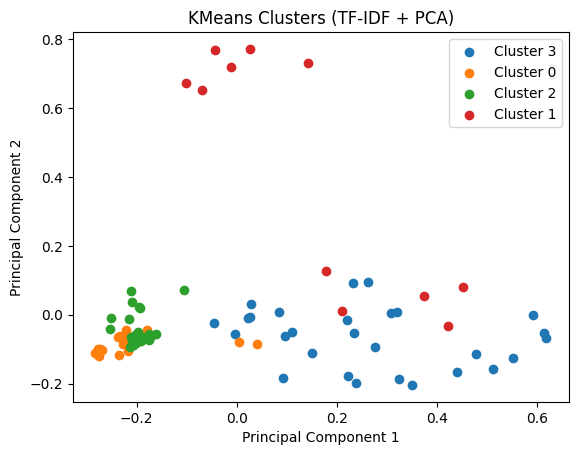

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert sparse to dense
X_dense = X_tfidf.toarray()

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

plt.figure()

clusters = df_cluster["cluster"].unique()

for cluster in clusters:
    idx = df_cluster["cluster"] == cluster
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        label=f"Cluster {cluster}"
    )

plt.legend()
plt.title("KMeans Clusters (TF-IDF + PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Manual inspection

In [51]:
cluster_labels = {
    0: "0",
    1: "1",
    2: "2",
    3: "3"
}

df_aux = df.merge(
    df_cluster[["id", "cluster"]],
    on="id",
    how="left"
)

df_aux["cluster_label"] = df_aux["cluster"].map(cluster_labels)

columns_to_view = [
    "name",
    "reviews.text",
    "reviews.title",
    "categories",
    "cluster_label"
]

df_aux[columns_to_view]


,name,reviews.text,reviews.title,categories,cluster_label
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,Kindle,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,very fast,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,Good!!!,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,Fantastic Tablet for kids,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
...,...,...,...,...,...
66563,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",I got 2 of these for my 8 yr old twins. My 11 ...,Xmas gift,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",1
66564,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",I bought this for my niece for a Christmas gif...,yes it is a great tablet.,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",1
66565,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...","Very nice for light internet browsing, keeping...",You get a lot for the price!,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",1
66566,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",This Tablet does absolutely everything I want!...,You get the entire World for less than $100!,"Fire Tablets,Tablets,All Tablets,Amazon Tablet...",1


In [52]:
for label in df_aux["cluster_label"].unique():
    print(f"\n=== {label} ===")
    display(df_aux[df_aux["cluster_label"] == label][columns_to_view].head(20))



=== 3 ===


,name,reviews.text,reviews.title,categories,cluster_label
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This product so far has not disappointed. My c...,Kindle,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",great for beginner or experienced person. Boug...,very fast,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I've had my Fire HD 8 two weeks now and I love...,Good!!!,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I bought this for my grand daughter when she c...,Fantastic Tablet for kids,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
5,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",This amazon fire 8 inch tablet is the perfect ...,Just what we expected,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
6,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Great for e-reading on the go, nice and light ...",great e-reader tablet,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
7,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","I gave this as a Christmas gift to my inlaws, ...",Great for gifts,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
8,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Great as a device to read books. I like that i...,Great for reading,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3
9,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",I love ordering books and reading them with th...,Great and lightweight reader,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",3



=== 2 ===


,name,reviews.text,reviews.title,categories,cluster_label
2881,"Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...",Finally received the Kindle Lighted Leather Co...,"Lightweight, good viewing area. 1,","Electronics,eBook Readers & Accessories,Covers...",2
2882,"Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...","I owned a Kindle Keyboard for about a year, an...",A Step Down In Quality,"Electronics,eBook Readers & Accessories,Covers...",2
2883,"Amazon Kindle Lighted Leather Cover,,,\r\nKind...",I purchased this Kindle case in the Saddle Tan...,High Quality Case For Your Kindle,"Electronics,eBook Readers & Accessories,Covers...",2
2884,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",I have had the Kindle Keyboard with it's light...,I recieved it today!,"Electronics,eBook Readers & Accessories,Covers...",2
2885,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",I read every single review for this cover befo...,Best Option Out There,"Electronics,eBook Readers & Accessories,Covers...",2
2886,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",The Kindle is my first e-ink reader. I own an ...,"Worth the money. Not perfect, but very very go...","Kindle Store,Amazon Devices,Electronics",2
2887,"Kindle Keyboard,,,\r\nKindle Keyboard,,,","I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...","Kindle Store,Amazon Devices,Electronics",2
2888,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",UPDATE NOVEMBER 2011:My review is now over a y...,Kindle vs. Nook (updated),"Kindle Store,Amazon Devices,Electronics",2
2889,"Kindle Keyboard,,,\r\nKindle Keyboard,,,","I'm a first-time Kindle owner, so I have nothi...","I Wanted a Dedicated E-Reader, and That's What...","Kindle Store,Amazon Devices,Electronics",2
2890,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",I woke up to a nice surprise this morning: a n...,"Not the perfect do-it-all device, but very clo...","Kindle Store,Amazon Devices,Electronics",2



=== 1 ===


,name,reviews.text,reviews.title,categories,cluster_label
3063,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 ...",My grandkids play on my smaller one. Thought I...,I like the bigger screen.,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3064,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 ...",It has such a BIG screen to see better. It loa...,The kindle fire HD 8 is really great!,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3065,Amazon 5W USB Official OEM Charger and Power A...,Fast fun tablet with great speakers compared t...,Great tablet,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3066,Amazon 5W USB Official OEM Charger and Power A...,Easy-to-use. Lots of books obviously but also ...,Awesome product,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3067,Amazon 5W USB Official OEM Charger and Power A...,I have always had a kindle fire but I had one ...,Love it,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3068,Amazon 5W USB Official OEM Charger and Power A...,Dont have option for password ask you before b...,Not really statisfied with features,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3069,Amazon 5W USB Official OEM Charger and Power A...,My husband's previous tablet died a sudden dea...,"Nice tablet, great price.","Tablets,Fire Tablets,Computers & Tablets,All T...",1
3070,Amazon 5W USB Official OEM Charger and Power A...,meh. it works. i find it difficult to navigate...,amazon fire hd8,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3071,Amazon 5W USB Official OEM Charger and Power A...,"Love my new Kindle! Only had to login, and all...",Excellant Purchase!,"Tablets,Fire Tablets,Computers & Tablets,All T...",1
3072,Amazon 5W USB Official OEM Charger and Power A...,Great tab for my kids. This is the third fire ...,Great buy,"Tablets,Fire Tablets,Computers & Tablets,All T...",1



=== 0 ===


,name,reviews.text,reviews.title,categories,cluster_label
21562,"Echo (White),,,\r\nEcho (White),,,",Stay away from the certified refurbished Amazo...,"Purchase a new one, stay away from the refurbi...","Categories,Streaming Media Players,Electronics",0
21563,"Echo (White),,,\r\nEcho (White),,,",I seriously wonder why it took me to get FireT...,"Netflix, HBO Go, Amazon Prime and XBMC on one ...","Categories,Streaming Media Players,Electronics",0
21564,"Echo (White),,,\r\nEcho (White),,,","Love it, had the stick and it was kinda slow n...",Great,"Categories,Streaming Media Players,Electronics",0
21565,"Echo (White),,,\r\nEcho (White),,,","This box is wonderful, meets my expectations p...",Happy with my Amazon fire tv,"Categories,Streaming Media Players,Electronics",0
21566,"Echo (White),,,\r\nEcho (White),,,",I bought this thinking since we'd bought sever...,Never booted,"Categories,Streaming Media Players,Electronics",0
21567,"Echo (White),,,\r\nEcho (White),,,",Certified garbage! Lesson learned about paying...,Certified Garbage!,"Categories,Streaming Media Players,Electronics",0
21568,"Echo (White),,,\r\nEcho (White),,,",I bought this after being an avid Apple fan fo...,Much better than Apple TV!,"Categories,Streaming Media Players,Electronics",0
21569,"Echo (White),,,\r\nEcho (White),,,",I bought this thing refurbished. I find that I...,Refurbished version is giving me problems with...,"Categories,Streaming Media Players,Electronics",0
21570,"Echo (White),,,\r\nEcho (White),,,",I love this product. Perfect size for travel. ...,Love Kindle Fire,"Computers & Tablets,Tablets,All Tablets,Comput...",0
21571,"Echo (White),,,\r\nEcho (White),,,",Great little tablet once you get the hang of i...,Good Intro Tablet,"Computers & Tablets,Tablets,All Tablets,Comput...",0



=== nan ===


,name,reviews.text,reviews.title,categories,cluster_label


Manual mapping

After inspecting the products in each cluster, we adjust the clusters suggested by kmeans to what makes sense from a logical/business pov

In [53]:
# manual mapping
"""
kmeans cluster - category
cluster 0 – smart speakers
cluster 1 – tablets 
cluster 2 – accesories and chargers
cluster 3-  tablets
"""

cluster_to_macro = {
    0: "smart speakers",
    1: "tablets",
    2: "accessories and chargers",
    3: "tablets"
}

df_cluster["macro_category"] = df_cluster["cluster"].map(cluster_to_macro)
df_cluster[["id", "cluster", "macro_category"]].head(10)

,id,cluster,macro_category
0,AV-ETMhgYSSHbkXwpNb9,3,tablets
1,AV-EVZITKZqtpbFMSoqc,3,tablets
2,AV-XeQLWuC1rwyj_gbP5,0,smart speakers
3,AV1YnR7wglJLPUi8IJmi,0,smart speakers
4,AV1YnRtnglJLPUi8IJmV,3,tablets
5,AV2ElNnuvKc47QAVouhY,2,accessories and chargers
6,AVpe5Q3sLJeJML43xt5X,2,accessories and chargers
7,AVpe6nyKLJeJML43yOe2,2,accessories and chargers
8,AVpe7AsMilAPnD_xQ78G,3,tablets
9,AVpe7JuRilAPnD_xQ_M6,2,accessories and chargers


In [54]:
df_cluster["macro_category"].value_counts()


macro_category
tablets                     39
accessories and chargers    26
smart speakers              18
Name: count, dtype: int64

In [55]:
df_cluster.head()

,id,name,extracted_category,product_text,cluster,macro_category
0,AV-ETMhgYSSHbkXwpNb9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon Devices Tablets & E-Readers E-Readers,All-New Kindle Oasis E-reader - 7 High-Resolut...,3,tablets
1,AV-EVZITKZqtpbFMSoqc,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon Devices Amazon Tablets & E-Readers,All-New Kindle Oasis E-reader - 7 High-Resolut...,3,tablets
2,AV-XeQLWuC1rwyj_gbP5,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon Devices Amazon See more Amazon Fire TV ...,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,0,smart speakers
3,AV1YnR7wglJLPUi8IJmi,"Echo (White),,,\r\nEcho (White),,,",All Tablets Computers/Tablets & Networking Tab...,"Echo (White),,,\r\nEcho (White),,, All Tablets...",0,smart speakers
4,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,TVs & Electronics Computers & Laptops Tablets ...,Amazon Kindle Paperwhite - eBook reader - 4 GB...,3,tablets


PREPROCESSING FOR REVIEW GENERATION: GRADING INTENSITY AND SORTING

In [56]:
# first we add the classification obtained with SVM to the dataset
df_sa["svm_sentiment"] = svm_pipeline.predict(df_sa["full_review"])

get the probabilities of each review for positive, negative and neutral with LR

In [57]:
# we get the probabilities of each review for positive, negative and neuttral
probabilities = lr_pipeline.predict_proba(df_sa["full_review"])
classes = lr_pipeline.named_steps["clf"].classes_

In [58]:
print(classes)  # to check

['negative' 'neutral' 'positive']


In [59]:
# we get position of the column for each class
pos_idx = list(classes).index("positive")
neg_idx = list(classes).index("negative")
neu_idx = list(classes).index("neutral")

# we add each column with a name to our dataframe
df_sa["prob_positive"] = probabilities[:, pos_idx]
df_sa["prob_negative"] = probabilities[:, neg_idx]
df_sa["prob_neutral"]  = probabilities[:, neu_idx]

Create Intensity metric for each review

Because we want to produce a ranking and ultimately display products on the extremes (top positive and top negative), it's more appropiate to use the difference between positive probability and negative probability rather than just the isolated positive or negative probability. 

In [60]:
# values close to 1 are the most positive. -1 the most negative.
df_sa["sentiment_intensity"] = (
    df_sa["prob_positive"] - df_sa["prob_negative"]
)

In [61]:
# quick check
df_sa.head()

,id,asins,name,brand,manufacturer,categories,reviews.title,reviews.text,reviews.rating,reviews.doRecommend,reviews.numHelpful,full_review,aux_sentiment,svm_sentiment,prob_positive,prob_negative,prob_neutral,sentiment_intensity
0,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Kindle,This product so far has not disappointed. My c...,5.0,True,0.0,Kindle This product so far has not disappointe...,positive,positive,0.895200,0.073127,0.031673,0.822073
1,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",very fast,great for beginner or experienced person. Boug...,5.0,True,0.0,very fast great for beginner or experienced pe...,positive,positive,0.604006,0.042667,0.353327,0.561340
2,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...,5.0,True,0.0,Beginner tablet for our 9 year old son. Inexpe...,positive,positive,0.359825,0.022323,0.617852,0.337502
3,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Good!!!,I've had my Fire HD 8 two weeks now and I love...,4.0,True,0.0,Good!!! I've had my Fire HD 8 two weeks now an...,positive,positive,0.965830,0.001504,0.032666,0.964326
4,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Fantastic Tablet for kids,I bought this for my grand daughter when she c...,5.0,True,0.0,Fantastic Tablet for kids I bought this for my...,positive,positive,0.940215,0.021258,0.038527,0.918957


MERGE PIPELINE

In [62]:
df_master = df_sa.merge(
    df_cluster[["id", "macro_category"]],
    on="id",
    how="left"
)

In [63]:
df_master["macro_category"].isna().sum()

5124

In [64]:
print("Unique IDs in df_sa:", df_sa["id"].nunique())
print("Unique IDs in df_cluster:", df_cluster["id"].nunique())

Unique IDs in df_sa: 92
Unique IDs in df_cluster: 83


In [65]:
# 9 products were excluded because they were not assigned to any cluster after preprocessing and clustering steps.

ids_sa = set(df_sa["id"].unique())
ids_cluster = set(df_cluster["id"].unique())

missing_ids = ids_sa - ids_cluster

print("Number of missing product IDs:", len(missing_ids))

Number of missing product IDs: 9


In [66]:
df_master = df_master[df_master["macro_category"].notna()]

In [67]:
df_master["macro_category"].isna().sum()

0

In [68]:
df_master["macro_category"].value_counts()

macro_category
tablets                     37369
accessories and chargers    13083
smart speakers              10992
Name: count, dtype: int64

In [69]:
print("Remaining products:", df_master["id"].nunique())
print("Remaining reviews:", len(df_master))
print(df_master["macro_category"].value_counts())

Remaining products: 83
Remaining reviews: 61444
macro_category
tablets                     37369
accessories and chargers    13083
smart speakers              10992
Name: count, dtype: int64


In [70]:
df_master.head()

,id,asins,name,brand,manufacturer,categories,reviews.title,reviews.text,reviews.rating,reviews.doRecommend,reviews.numHelpful,full_review,aux_sentiment,svm_sentiment,prob_positive,prob_negative,prob_neutral,sentiment_intensity,macro_category
0,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Kindle,This product so far has not disappointed. My c...,5.0,True,0.0,Kindle This product so far has not disappointe...,positive,positive,0.895200,0.073127,0.031673,0.822073,tablets
1,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",very fast,great for beginner or experienced person. Boug...,5.0,True,0.0,very fast great for beginner or experienced pe...,positive,positive,0.604006,0.042667,0.353327,0.561340,tablets
2,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...,5.0,True,0.0,Beginner tablet for our 9 year old son. Inexpe...,positive,positive,0.359825,0.022323,0.617852,0.337502,tablets
3,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Good!!!,I've had my Fire HD 8 two weeks now and I love...,4.0,True,0.0,Good!!! I've had my Fire HD 8 two weeks now an...,positive,positive,0.965830,0.001504,0.032666,0.964326,tablets
4,AVqkIhwDv8e3D1O-lebb,B01AHB9CN2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Fantastic Tablet for kids,I bought this for my grand daughter when she c...,5.0,True,0.0,Fantastic Tablet for kids I bought this for my...,positive,positive,0.940215,0.021258,0.038527,0.918957,tablets


Por cada macro_category:

Calcular score agregado por producto (basado en sentiment_intensity).

Ordenar productos dentro de la categoría.

Elegir:

Top N productos

Worst product(s)

Pasar al LLM:

Todas las reviews de esos productos

O las reviews completas del top/worst seleccionado


Trabajar a nivel producto.

Concatenar reviews por producto.

Hacer ranking antes del LLM.

Dejar al LLM solo la redacción.

Create product-level dataset to feed LLM

Design

- For each macro_category compute an aggregated score per product (based on sentiment_intensity).

- Rank products within the category.

- All reviews of products

- Concatenate reviews per product.

- Let the LLM handle only the writing and summarization.

In [71]:
# Create one register per product and aggregate reviews

df_product = (
    df_master.groupby("id")
    .agg({
        "name": "first",
        "brand": "first",
        "manufacturer": "first",
        "macro_category": "first",
        "reviews.text": lambda x: " ".join(x),
        "sentiment_intensity": ["mean", "count"]
    })
)

# Flatten multi-index columns
df_product.columns = [
    "name",
    "brand",
    "manufacturer",
    "macro_category",
    "all_reviews_text",
    "avg_sentiment_intensity",
    "num_reviews"
]

df_product = df_product.reset_index()


In [72]:
# add ranking 
df_product["rank_in_category"] = (
    df_product
    .groupby("macro_category")["avg_sentiment_intensity"]
    .rank(ascending=False, method="first")
)

df_product["rank_worst_in_category"] = (
    df_product
    .groupby("macro_category")["avg_sentiment_intensity"]
    .rank(ascending=True, method="first")
)


In [74]:
df_product.head()

,id,name,brand,manufacturer,macro_category,all_reviews_text,avg_sentiment_intensity,num_reviews,rank_in_category,rank_worst_in_category
0,AV-ETMhgYSSHbkXwpNb9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,Amazon,tablets,"The best Kindle ever, for me, is still the hug...",0.821546,4,2.0,38.0
1,AV-EVZITKZqtpbFMSoqc,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,Amazon,tablets,Love my new kindle!!! I would recommend this t...,0.716093,22,23.0,17.0
2,AV-XeQLWuC1rwyj_gbP5,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,Amazon,smart speakers,A lazy mans drean when it is combined with Ale...,0.862554,4,2.0,17.0
3,AV1YnR7wglJLPUi8IJmi,"Echo (White),,,\r\nEcho (White),,,",Amazon,Amazon,smart speakers,I got a great tablet from a great company with...,0.654222,372,13.0,6.0
4,AV1YnRtnglJLPUi8IJmV,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Amazon,Amazon,tablets,I was looking for a reader that was light enou...,0.817425,3176,3.0,37.0


export csv

In [73]:
df_product.to_csv("../data/df_product_for_llm.csv", index=False)